In [2]:
import sys
print(sys.version)

import tensorflow as tf
print(tf.__version__)

import numpy as np
np.set_printoptions(threshold=np.inf)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:52:09) 
[Clang 14.0.6 ]
2.12.0


In [3]:
"""
1. 数据加载
将训练测试数据划分好后放在同一个文件目录下，使用tf.keras.preprocessing.image_dataset_from_directory()函数构造数据集。
函数的具体用法见：https://blog.csdn.net/qq_40108803/article/details/110408217

对训练数据和验证数据进行one-hot编码，便于计算损失，读入图像时统一图片大小size为128*128。batch为64，每次迭代从中取64个样本。
class_names中保存的是根据文件夹名称生成的标签。
"""
# 三分类，卷积神经网络
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,datasets,Sequential
import os  # 设置一下输出框打印的内容
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '2'输出栏只打印error信息，其他乱七八糟的信息不打印
 
#（1）数据获取
# 加载训练集数据
filepath1 = '/Users/paroniasun/Documents/DeepLearning/CNN/conf/train_jpg'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath1,
    label_mode='categorical',  # "int", "categorical"表示onehot, "binary", or None
    seed=123,
    image_size=(128, 128),  # resize图片大小
    batch_size=64)
 
# 加载验证集数据
filepath2 = '/Users/paroniasun/Documents/DeepLearning/CNN/conf/val_jpg'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath2,
    label_mode='categorical',
    seed=123,
    image_size=(128, 128),
    batch_size=64)
 
# 加载测试集数据
filepath3 = '/Users/paroniasun/Documents/DeepLearning/CNN/conf/test_template'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath3,
    label_mode='int',
    seed=123,
    image_size=(128, 128),
    batch_size=64) 
 
# 类别名称
class_names = train_ds.class_names
print('类别有：',class_names)
# 类别有： ['cats', 'dogs', 'panda']

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 34 files belonging to 1 classes.
类别有： ['cats', 'dogs']


img.shape: (64, 128, 128, 3)
label.shape: (64, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

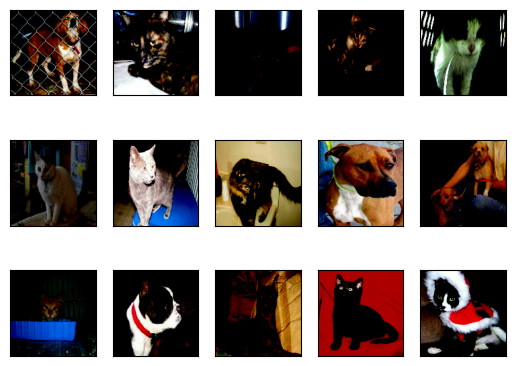

In [4]:
"""
2. 数据预处理
使用.map()对dataset中的数据进行processing函数中的操作，对每个点的像素值从[0,255]变成[-1,1]，.shuffle()对数据集重新洗牌打散，但不改变x和y之间的对应关系。

train_ds.take(1) 是指从训练集数据集中取出1个batch的数据，返回值img存放图像数据，label存放图像的标签。
"""
#（2）数据预处理
def processing(image, label): 
    image = 2 * tf.cast(image, tf.float32) / 255.0 - 1  #[-1,1]之间
    label = tf.cast(label, tf.int32)  # 修改数据类型
    return (image, label)
 
train_ds = train_ds.map(processing).shuffle(10000)  #洗牌
val_ds = val_ds.map(processing).shuffle(10000)
test_ds = test_ds.map(processing).shuffle(10000)
 
#（2）数据检查
for img, label in train_ds.take(1): # 取出一个batch的数据，一个batch有64个样本
    print('img.shape:', img.shape)   # img.shape: (64, 128, 128, 3)
    print('label.shape:', label.shape)  # label.shape: (64, 3)
 
# 数据集展示
import matplotlib.pyplot as plt
for img,label in train_ds.take(1): #取一个batch
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(img[i])  # 每张图像的shape为(4, 256, 256, 3) 
        plt.xticks([])  # 不显示xy轴坐标刻度
        plt.yticks([])
plt.show()

In [5]:
"""
3. 网络构建
这里构造一个6层的神经网络，使用Sequential()容器堆叠网络各层，layers.Conv2D()构造卷积层，卷积核size为3*3。
layers.MaxPool2D()构造池化层，采用最大池化方法。指定padding='same'填充图像，在传播过程中保证生成的特征图的size不变，只改变其channel。
指定layers.Dropout(0.2)每次迭代该层每个神经元都有20%的概率被杀死，防止网络出现过拟合现象。

在卷积池化层和全连接层之间需要指定一个Flatten层layers.Flatten()，输入至全连接层的图像需要是一个二维tensor，
假设卷积池化层输出的shape为[b,1,1,64]，那么传入全连接层的shape需要w是[b,64]
"""
#（3）网络构建
# ==1== 卷积和池化层，2次卷积1次池化
network = Sequential()
# unit1
network.add(layers.Conv2D(32, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.Conv2D(32, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))
# unit2
network.add(layers.Conv2D(64, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.Conv2D(64, kernel_size=[3,3], strides=1, padding='same', activation=tf.nn.relu))
network.add(layers.MaxPool2D(pool_size=[2,2], strides=2, padding='same'))
# dropout层
network.add(layers.Dropout(0.2)) #每个神经元都有0.2的概率被杀死
 
# ==2== Flatten层，连接卷积池化层和全连接层
network.add(layers.Flatten())
 
# ==3== 全连接层
network.add(layers.Dense(128, activation=tf.nn.relu))
network.add(layers.Dense(2))  # 输出层logits层
 
# ==4== 指定输入层
network.build(input_shape=[None, 128, 128, 3])
 
# ==5== 查看网络结构
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [6]:
"""
4. 网络配置
采用学习率指数衰减的方法方法，tf.keras.optimizers.schedules.ExponentialDecay()，起初梯度变化大一点能更快接近目标，
后续梯度变化不断减小，越来越逼近最优点。设置早停策略，因为神经网络在不断迭代的过程中，
准确率不会一直在上升，如果找到某一极值点，且后续多次迭代过程中，网络效果没有变的更优的迹象，就使用之前的极值点的结果作为最优解。
"""
#（4）网络配置
# 设置动态学习率指数衰减
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=0.001, #初始学习率
                        decay_steps=2,  # 衰减步长
                        decay_rate=0.96)  # 衰减率
 
# 编译
network.compile(optimizer=optimizers.legacy.Adam(learning_rate=exponential_decay), 
                loss=tf.losses.CategoricalCrossentropy(from_logits=True), # 交叉熵损失
                metrics=['accuracy'])  # 准确率指标
 
# 早停策略
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', # 验证集的准确率作为指标
    patience = 10, # 最多忍受多少个次循环没有改进
    restore_best_weights = True)  # 发生早停时，自动寻找最优的monitor参数

In [11]:
"""
5. 模型训练
"""
#（5）网络训练
# 指定训练集、验证集、迭代次数
# 训练目标和验证目标需要时one_hot编码后的
model = network.fit(train_ds,  # 训练集
                    validation_data=val_ds,  # 验证集 
                    epochs=1,  # 迭代多少次
                    callbacks= early_stopping, # 回调函数，在训练过程中的适当时机被调用
                    shuffle = True, # 每轮迭代之前洗牌
                    verbose = 1 # 0为不在标准输出流输出日志信息，1:显示进度条，2:每个epoch输出一行记录
                    )

313/313 [==============================] - 263s 822ms/step - loss: 0.6480 - accuracy: 0.6295 - val_loss: 0.6082 - val_accuracy: 0.7096


In [67]:
"""
5. 模型导出

保存整个模型（包含权重和模型结构）：
使用tf.keras.models.save_model函数。
# 假设您的模型名称为model
model.save('my_model.h5')  # 仅保存权重和模型结构
保存后，您可以使用load_model函数来加载整个模型：
model = tf.keras.models.load_model('my_model.h5')

只保存权重：
使用model.save_weights函数。
model.save_weights('weights.h5')  # 仅保存权重
之后，您可以单独加载权重：
model.load_weights('weights.h5')

导出为TensorFlow Lite格式：
使用tf.keras.models.save函数，并设置filepath参数的扩展名为.tflite。
model.save('my_model.tflite', save_format='tf')
在移动设备或嵌入式设备上，您可以使用TensorFlow Lite的Interpreter API来加载和运行模型。

导出为ONNX格式：
使用tf.onnx.export函数。
tf.onnx.export(model, 'my_model.onnx', opset_version=10)  # ONNX版本10
之后，您可以使用其他支持ONNX的库来加载模型进行预测，例如PyTorch或MXNet。
"""
network.save('/Users/paroniasun/Documents/DeepLearning/CNN/model/cnn_animal_classification.h5')  # 仅保存权重和模型结构


Text(0.5, 1.0, 'Loss')

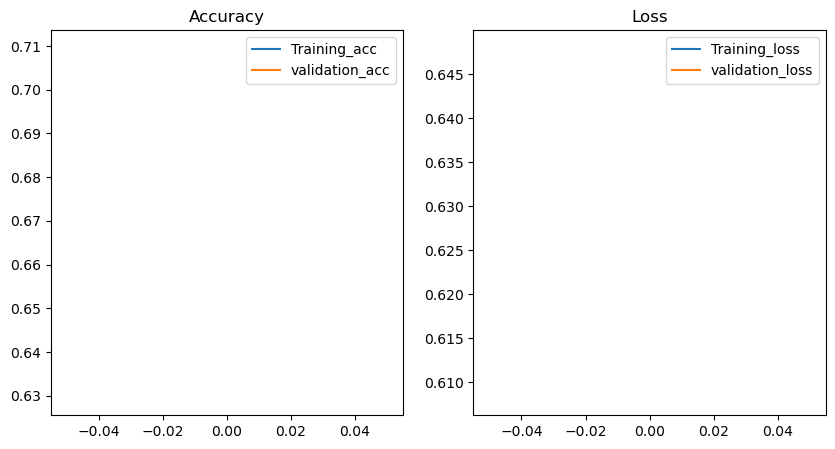

In [12]:
"""
6. 模型评估
比较网络训练集和验证集上的准确率和损失，绘图比较
"""
#（6）模型评估
# ==1== 计算准确率
train_acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
 
# ==2== 损失
train_loss = model.history['loss']
val_loss = model.history['val_loss']
 
# ==3== 曲线图
epochs_range = range(len(train_acc))  # 横坐标，网络循环了几次
 
# 准确率曲线
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training_acc')
plt.plot(epochs_range, val_acc, label='validation_acc')
plt.legend()
plt.title('Accuracy')
 
# 损失曲线
plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training_loss')
plt.plot(epochs_range, val_loss, label='validation_loss')
plt.legend()
plt.title('Loss')

1/1 [==============================] - 0s 15ms/step
测试结果： ['dogs', 'dogs', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats']
真实结果： ['cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats', 'cats']


Text(0.5, 42.7222222222222, '预测值')

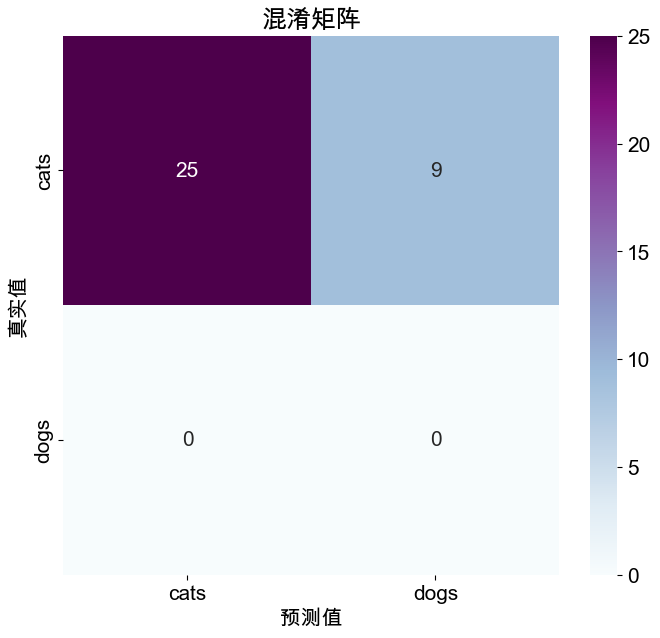

In [10]:
"""
7. 预测
采用测试集中的图像数据对网络进行预测，network.predict()得到输入图像分别属于三个分类的数值，返回numpy类型，
使用np.argmax()找到最大值的索引，该索引对应的class_names标签就是预测得到的该图像所属的分类。
"""
network = tf.keras.models.load_model('/Users/paroniasun/Documents/DeepLearning/CNN/model/cnn_animal_classification.h5')
# 编译
network.compile(optimizer=optimizers.legacy.Adam(learning_rate=exponential_decay), 
                loss=tf.losses.CategoricalCrossentropy(from_logits=True), # 交叉熵损失
                metrics=['accuracy'])  # 准确率指标

#（7）预测
test_pred = []
test_target = []
 
for images, targets in test_ds:  #取一个batch的测试集生成混淆矩阵
    
    for image, label in zip(images, targets): # 每次从batch中取出一组
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, axis=0) 
        # 使用模型预测图片中的动物
        prediction = network.predict(img_array)
        # 预测结果是预测值最大值索引对应的位置
        test_pred.append(class_names[np.argmax(prediction)])
        # 保存真实值的标签
        test_target.append(class_names[label])  # label没有做onehot编码
 
print('测试结果：',test_pred[:10])
print('真实结果：',test_target[:10])
 
#（8）混淆矩阵
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  #宋体
plt.rcParams['font.size'] = 15  #设置字体大小
 
# 生成混淆矩阵
conf_numpy = confusion_matrix(test_target, test_pred)
# 将矩阵转化为 DataFrame
conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
plt.figure(figsize=(8,7))
    
sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
plt.title('混淆矩阵')
plt.ylabel('真实值')
plt.xlabel('预测值')

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.
